[0.  0.1 0.2 0.3 0.4]
[0.         0.09983342 0.19866933 0.29552021 0.38941834]


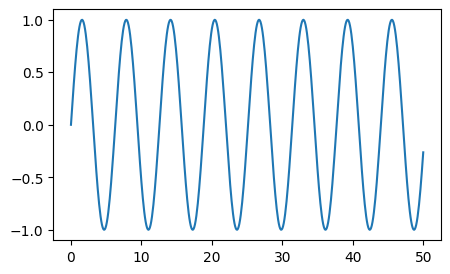

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# evenly spaced x-values and corresponding y-values where y=sin(x)
x = np.linspace(0, 50, 501)
y = np.sin(x)

print(x[:5])
print(y[:5])

plt.figure(figsize=(5, 3))
plt.plot(x, y)
plt.show()

In [12]:
# shove it all in a dataframe
import pandas as pd

data = {'x': x, 'y': y}
df = pd.DataFrame(data)

print("DataFrame created:")
display(df.head())

DataFrame created:


,x,y
0,0.0,0.000000
1,0.1,0.099833
2,0.2,0.198669
3,0.3,0.295520
4,0.4,0.389418


In [13]:
# Splitting the data, making the last 10% test data, not a randomised split, since sequence matters.
print(f"Total number of records: {int(len(df))}")
split_index = int(0.9 * len(df))
train_df = df[:split_index]
test_df = df[split_index:]
print(f"Train: {int(len(train_df))}")
print(f"Test: {int(len(test_df))}")

Total number of records: 501
Train: 450
Test: 51


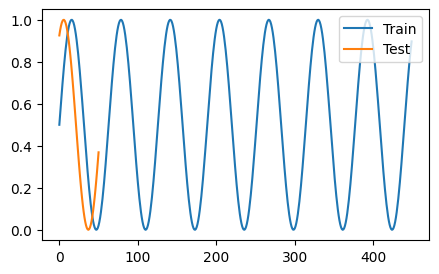

In [14]:
from sklearn.preprocessing import MinMaxScaler

# scaling y values to be between 0 and 1 for efficient training and prediction
# output values will be inverse transformed later for interpretation
scaler = MinMaxScaler()

scaler.fit(train_df[['y']])

train_scaled = scaler.transform(train_df[['y']])
test_scaled = scaler.transform(test_df[['y']])

plt.figure(figsize=(5, 3))
plt.plot(train_scaled, label='Train')
plt.plot(test_scaled, label='Test')
plt.legend(loc='upper right')
plt.show()

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# reshape(n_rows, n_cols) where -1 means infer
train_scaled = train_scaled.reshape(-1, 1)
test_scaled = test_scaled.reshape(-1, 1)

n_input = 50 # number of steps in a sequence
batch_size = 32 # number of sequences to be processed at once, 32 is a common default

# generates the right sequences when called, does not store them up front
# e.g [0, 1, 2, 3, 4, 5] [1, 2, 3, 4, 5, 6] [2, 3, 4, 5, 6, 7] - 3 batches of n_input = 6, stride is 1 by default

train_generator = TimeseriesGenerator(train_scaled, train_scaled,
                                      length=n_input,
                                      batch_size=batch_size)

test_generator = TimeseriesGenerator(test_scaled, test_scaled,
                                     length=n_input,
                                     batch_size=batch_size)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential([
    LSTM(50, input_shape=(n_input, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# history records the fitting progress including loss info
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.3273 - val_loss: 0.0302
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0721 - val_loss: 0.0153
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0536 - val_loss: 0.0180
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0360 - val_loss: 0.0138
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0273 - val_loss: 0.0105
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0173 - val_loss: 0.0079
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0066 - val_loss: 0.0028
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.9069e-04 - val_loss: 3.9953e-04
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 7.8165e-04 - val_loss: 5.6937e-04
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.1595e-04 - val_loss: 6.6781e-04


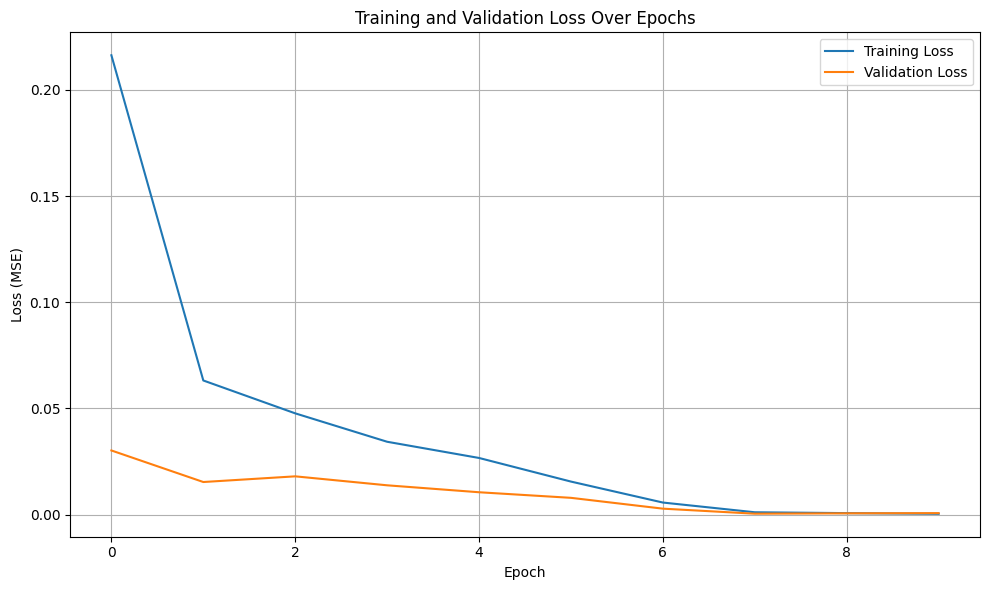

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Training loss**: How well the model fits the data.  
**Validation loss**: How well the model generalises to unseen data.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# get the last 20 values of the training data and reshape it to be passed to the model (1 sequence/batch, 20 timesteps each with 1 feature)
last_sequence = train_scaled[-n_input:]
last_sequence = last_sequence.reshape((1, n_input, 1))

# predict the next scaled value using the most recent sequence and... unscale it :) (inverse transform)
predicted_next_scaled = model.predict(last_sequence)
predicted_next = scaler.inverse_transform(predicted_next_scaled)

# the actual value is the first value in the test set, inverse transform and compare to the predicted value.
actual_next_scaled = test_scaled[0]
actual_next = scaler.inverse_transform(actual_next_scaled.reshape(1, -1))

# [0][0] just getting the first value from a 2D array
print(f"Predicted next value: {predicted_next[0][0]:.5f}")
print(f"Actual next value   : {actual_next[0][0]:.5f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Predicted next value: 0.87688
Actual next value   : 0.85090


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

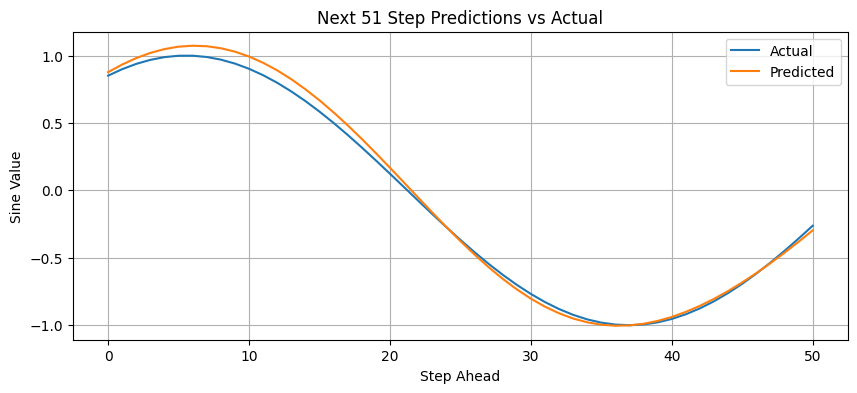

In [19]:
# essentially does the same thing as the last snippet, but in a loop, and stores outputs in arrays
n_future = 51 # I'm using 51 instead of 25 to see more of the sine curve (51 values in test set)

# last 20 training values, and reshaped
current_sequence = train_scaled[-n_input:].reshape(1, n_input, 1)
predictions_scaled = [] # use list instead of array when appending for better memory efficiency

for i in range(n_future):
    next_pred = model.predict(current_sequence)[0][0]
    predictions_scaled.append(next_pred) # saves prediction
    # prediction is appended to the current_sequence, for the next prediction to be made. (shifting the window by one)
    current_sequence = np.append(current_sequence[:,1:,:], [[[next_pred]]], axis=1)

# convert list to numpy array and reshape to for inverse transform
predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)

# inverse transform predictions and actual values to plot
predictions = scaler.inverse_transform(predictions_scaled)
actual_values = scaler.inverse_transform(test_scaled[:n_future])

plt.figure(figsize=(10, 4))
plt.plot(range(n_future), actual_values, label='Actual')
plt.plot(range(n_future), predictions, label='Predicted')
plt.title(f'Next {n_future} Step Predictions vs Actual')
plt.xlabel('Step Ahead')
plt.ylabel('Sine Value')
plt.legend()
plt.grid(True)
plt.show()